# 🗑️ Trash-Buddy Model Training

## Overview
This notebook handles the third step of the Trash-Buddy pipeline: **Model Building and Training**. Based on the preprocessing from Step 2, we implement:

- Transfer learning model architecture (ResNet/EfficientNet)
- Data loaders with augmentation strategies
- Training loop with class weights for imbalanced data
- Validation and evaluation metrics
- Model checkpointing and saving

---

## 📊 Prerequisites from Step 2

From the preprocessing step, we have:
- **Train/Val/Test splits** saved as CSV files
- **Class weights** calculated for imbalanced data handling
- **Label encoders** for class mapping
- **Augmentation strategies** defined (standard + aggressive)
- **Image preprocessing** configuration (224×224, ImageNet normalization)

---

## 🎯 Objectives
1. Load preprocessed data and configurations
2. Implement PyTorch data loaders with augmentation
3. Build transfer learning model architecture
4. Set up training with class weights and appropriate loss function
5. Train model with validation monitoring
6. Evaluate on test set with detailed metrics
7. Save trained model and training artifacts


In [1]:
# Import necessary libraries
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.transforms import v2 as transforms_v2
import torch.nn.functional as F

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
 torch.cuda.manual_seed(42)
 torch.backends.cudnn.deterministic = True
 torch.backends.cudnn.benchmark = False

print("Libraries imported successfully!")


Using device: cpu
Libraries imported successfully!


## 📁 Load Preprocessed Data and Configurations

Load the data splits, class weights, and configurations from Step 2.


In [2]:
# Define paths
processed_data_dir = Path('processed_data')
data_dir = Path('Data')

# Load data splits
df_train = pd.read_csv(processed_data_dir /'train_split.csv')
df_val = pd.read_csv(processed_data_dir /'val_split.csv')
df_test = pd.read_csv(processed_data_dir /'test_split.csv')

# Load class weights
with open(processed_data_dir /'class_weights.json','r') as f:
 class_weight_dict = json.load(f)

# Load label classes
label_classes = np.load(processed_data_dir /'label_classes.npy', allow_pickle=True)

# Create label encoder
label_encoder = LabelEncoder()
label_encoder.classes_ = label_classes

print("=" * 80)
print("DATA LOADING")
print("=" * 80)
print(f"\n Data splits loaded:")
print(f" Training Set: {len(df_train):,} images")
print(f" Validation Set: {len(df_val):,} images")
print(f" Test Set: {len(df_test):,} images")

print(f"\n Class weights loaded: {len(class_weight_dict)} classes")
print(f"\n Label encoder loaded: {len(label_classes)} classes")

# Display class distribution
print(f"\n Training Set Class Distribution:")
train_dist = df_train['subcategory'].value_counts().sort_values()
print(train_dist)


DATA LOADING

✅ Data splits loaded:
   Training Set: 5,271 images
   Validation Set: 1,598 images
   Test Set: 1,619 images

✅ Class weights loaded: 18 classes

✅ Label encoder loaded: 18 classes

📊 Training Set Class Distribution:
subcategory
sanitary_napkin          196
batteries                196
kitchen_waste            207
stroform_product         220
paper_products           222
egg_shells               224
plastic_bottles          229
yard_trimmings           232
glass_containers         245
platics_bags_wrappers    247
ceramic_product          248
pesticides               257
coffee_tea_bags          264
diapers                  268
paints                   274
food_scraps              274
cans_all_type            486
e-waste                  982
Name: count, dtype: int64


## ⚙️ Training Configuration

Set up hyperparameters and model configuration.


In [3]:
# Training configuration
CONFIG = {
 # Image settings
'IMAGE_SIZE': 224,
'IMAGENET_MEAN': [0.485, 0.456, 0.406],
'IMAGENET_STD': [0.229, 0.224, 0.225],
 
 # Model settings
'MODEL_NAME':'resnet50', # Options:'resnet50','efficientnet_b0','mobilenet_v2'
'NUM_CLASSES': len(label_classes),
'PRETRAINED': True,
 
 # Training settings
'BATCH_SIZE': 32,
'NUM_EPOCHS': 50,
'LEARNING_RATE': 0.001,
'WEIGHT_DECAY': 1e-4,
'NUM_WORKERS': 0, # Set to 0 on Windows to avoid hanging issues
 
 # Learning rate scheduler
'USE_SCHEDULER': True,
'SCHEDULER_STEP_SIZE': 10,
'SCHEDULER_GAMMA': 0.1,
 
 # Early stopping
'USE_EARLY_STOPPING': True,
'EARLY_STOPPING_PATIENCE': 7,
'EARLY_STOPPING_MIN_DELTA': 0.001,
 
 # Checkpointing
'SAVE_BEST_MODEL': True,
'MODEL_SAVE_DIR': Path('models'),
}

# Create model save directory
CONFIG['MODEL_SAVE_DIR'].mkdir(exist_ok=True)

print("=" * 80)
print("TRAINING CONFIGURATION")
print("=" * 80)
for key, value in CONFIG.items():
 print(f" {key}: {value}")

print(f"\n Configuration set!")


TRAINING CONFIGURATION
   IMAGE_SIZE: 224
   IMAGENET_MEAN: [0.485, 0.456, 0.406]
   IMAGENET_STD: [0.229, 0.224, 0.225]
   MODEL_NAME: resnet50
   NUM_CLASSES: 18
   PRETRAINED: True
   BATCH_SIZE: 32
   NUM_EPOCHS: 50
   LEARNING_RATE: 0.001
   WEIGHT_DECAY: 0.0001
   NUM_WORKERS: 0
   USE_SCHEDULER: True
   SCHEDULER_STEP_SIZE: 10
   SCHEDULER_GAMMA: 0.1
   USE_EARLY_STOPPING: True
   EARLY_STOPPING_PATIENCE: 7
   EARLY_STOPPING_MIN_DELTA: 0.001
   SAVE_BEST_MODEL: True
   MODEL_SAVE_DIR: models

✅ Configuration set!


## 📦 PyTorch Dataset and DataLoader Implementation

Implement custom dataset class with augmentation support.


In [4]:
class WasteClassificationDataset(Dataset):
"""Custom Dataset for waste classification"""
 
 def __init__(self, dataframe, transform=None, is_aggressive_augment=False):
 self.dataframe = dataframe.reset_index(drop=True)
 self.transform = transform
 self.is_aggressive_augment = is_aggressive_augment
 
 # Encode labels
 self.labels = label_encoder.transform(dataframe['subcategory'].values)
 
 # Identify minority classes for aggressive augmentation
 self.minority_classes = []
 subcategory_counts = dataframe['subcategory'].value_counts()
 MINORITY_THRESHOLD = 250
 self.minority_classes = subcategory_counts[subcategory_counts < MINORITY_THRESHOLD].index.tolist()
 
 def __len__(self):
 return len(self.dataframe)
 
 def __getitem__(self, idx):
 img_path = self.dataframe.iloc[idx]['image_path']
 label = self.labels[idx]
 subcategory = self.dataframe.iloc[idx]['subcategory']
 
 # Load image
 try:
 image = Image.open(img_path).convert('RGB')
 except Exception as e:
 print(f"Error loading image {img_path}: {e}")
 # Return a blank image if loading fails
 image = Image.new('RGB',(CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE']), color='black')
 
 # Apply transforms
 if self.transform:
 # Use aggressive augmentation for minority classes during training
 if self.is_aggressive_augment and subcategory in self.minority_classes:
 # Apply aggressive transform
 image = self.transform['aggressive'](image)
 elif self.is_aggressive_augment:
 # Apply standard transform
 image = self.transform['standard'](image)
 else:
 # Validation/Test - no augmentation
 image = self.transform(image)
 
 return image, label

print(" Dataset class defined!")


✅ Dataset class defined!


## 🔄 Data Augmentation Transforms

Define transforms for standard and aggressive augmentation.


In [5]:
def get_transforms(is_training=False, is_aggressive=False):
"""Get transforms for training/validation"""
 
 if is_training:
 # Standard augmentation for all classes
 standard_transform = transforms.Compose([
 transforms.Resize((CONFIG['IMAGE_SIZE'] + 32, CONFIG['IMAGE_SIZE'] + 32)),
 transforms.RandomCrop(CONFIG['IMAGE_SIZE']),
 transforms.RandomHorizontalFlip(p=0.5),
 transforms.RandomRotation(15),
 transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
 transforms.ToTensor(),
 transforms.Normalize(mean=CONFIG['IMAGENET_MEAN'], std=CONFIG['IMAGENET_STD'])
 ])
 
 if is_aggressive:
 # Aggressive augmentation for minority classes
 aggressive_transform = transforms.Compose([
 transforms.Resize((CONFIG['IMAGE_SIZE'] + 32, CONFIG['IMAGE_SIZE'] + 32)),
 transforms.RandomCrop(CONFIG['IMAGE_SIZE']),
 transforms.RandomHorizontalFlip(p=0.5),
 transforms.RandomVerticalFlip(p=0.3),
 transforms.RandomRotation(30),
 transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
 transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), shear=10),
 transforms.ToTensor(),
 transforms.Normalize(mean=CONFIG['IMAGENET_MEAN'], std=CONFIG['IMAGENET_STD']),
 transforms.RandomErasing(p=0.2)
 ])
 
 return {
'standard': standard_transform,
'aggressive': aggressive_transform
 }
 else:
 return standard_transform
 else:
 # Validation/Test transforms(no augmentation)
 return transforms.Compose([
 transforms.Resize((CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE'])),
 transforms.ToTensor(),
 transforms.Normalize(mean=CONFIG['IMAGENET_MEAN'], std=CONFIG['IMAGENET_STD'])
 ])

# Create transforms
train_transforms = get_transforms(is_training=True, is_aggressive=True)
val_transforms = get_transforms(is_training=False)
test_transforms = get_transforms(is_training=False)

print(" Transforms defined!")
print(" - Training: Standard + Aggressive augmentation(for minority classes)")
print(" - Validation/Test: No augmentation")


✅ Transforms defined!
   - Training: Standard + Aggressive augmentation (for minority classes)
   - Validation/Test: No augmentation


## 📊 Create Data Loaders

Create PyTorch DataLoaders for training, validation, and test sets.


In [6]:
# Create datasets
train_dataset = WasteClassificationDataset(
 df_train, 
 transform=train_transforms, 
 is_aggressive_augment=True
)
val_dataset = WasteClassificationDataset(
 df_val, 
 transform=val_transforms, 
 is_aggressive_augment=False
)
test_dataset = WasteClassificationDataset(
 df_test, 
 transform=test_transforms, 
 is_aggressive_augment=False
)

# Fix NUM_WORKERS for Windows compatibility
import os
if os.name =='nt' and CONFIG['NUM_WORKERS'] > 0: # Windows
 print(" Windows detected - Setting NUM_WORKERS to 0 to avoid DataLoader hanging")
 CONFIG['NUM_WORKERS'] = 0

# Create data loaders
train_loader = DataLoader(
 train_dataset,
 batch_size=CONFIG['BATCH_SIZE'],
 shuffle=True,
 num_workers=CONFIG['NUM_WORKERS'],
 pin_memory=False # Disable on Windows/CPU
)

val_loader = DataLoader(
 val_dataset,
 batch_size=CONFIG['BATCH_SIZE'],
 shuffle=False,
 num_workers=CONFIG['NUM_WORKERS'],
 pin_memory=False # Disable on Windows/CPU
)

test_loader = DataLoader(
 test_dataset,
 batch_size=CONFIG['BATCH_SIZE'],
 shuffle=False,
 num_workers=CONFIG['NUM_WORKERS'],
 pin_memory=False # Disable on Windows/CPU
)

print("=" * 80)
print("DATA LOADERS CREATED")
print("=" * 80)
print(f" Training batches: {len(train_loader)}")
print(f" Validation batches: {len(val_loader)}")
print(f" Test batches: {len(test_loader)}")
print(f"\n Data loaders ready!")


DATA LOADERS CREATED
   Training batches: 165
   Validation batches: 50
   Test batches: 51

✅ Data loaders ready!


## 🏗️ Model Architecture

Build transfer learning model using pre-trained backbone.


In [7]:
def create_model(model_name='resnet50', num_classes=18, pretrained=True):
"""Create transfer learning model"""
 
 # Use weights parameter for newer torchvision versions
 try:
 if model_name =='resnet50':
 if pretrained:
 weights = models.ResNet50_Weights.DEFAULT
 else:
 weights = None
 model = models.resnet50(weights=weights)
 # Replace the final fully connected layer
 num_features = model.fc.in_features
 model.fc = nn.Linear(num_features, num_classes)
 
 elif model_name =='efficientnet_b0':
 if pretrained:
 weights = models.EfficientNet_B0_Weights.DEFAULT
 else:
 weights = None
 model = models.efficientnet_b0(weights=weights)
 num_features = model.classifier[1].in_features
 model.classifier[1] = nn.Linear(num_features, num_classes)
 
 elif model_name =='mobilenet_v2':
 if pretrained:
 weights = models.MobileNet_V2_Weights.DEFAULT
 else:
 weights = None
 model = models.mobilenet_v2(weights=weights)
 num_features = model.classifier[1].in_features
 model.classifier[1] = nn.Linear(num_features, num_classes)
 
 else:
 raise ValueError(f"Unknown model: {model_name}")
 except AttributeError:
 # Fallback for older torchvision versions
 if model_name =='resnet50':
 model = models.resnet50(pretrained=pretrained)
 num_features = model.fc.in_features
 model.fc = nn.Linear(num_features, num_classes)
 elif model_name =='efficientnet_b0':
 model = models.efficientnet_b0(pretrained=pretrained)
 num_features = model.classifier[1].in_features
 model.classifier[1] = nn.Linear(num_features, num_classes)
 elif model_name =='mobilenet_v2':
 model = models.mobilenet_v2(pretrained=pretrained)
 num_features = model.classifier[1].in_features
 model.classifier[1] = nn.Linear(num_features, num_classes)
 else:
 raise ValueError(f"Unknown model: {model_name}")
 
 return model

# Create model
model = create_model(
 model_name=CONFIG['MODEL_NAME'],
 num_classes=CONFIG['NUM_CLASSES'],
 pretrained=CONFIG['PRETRAINED']
)

# Move model to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 80)
print("MODEL ARCHITECTURE")
print("=" * 80)
print(f" Model: {CONFIG['MODEL_NAME']}")
print(f" Number of classes: {CONFIG['NUM_CLASSES']}")
print(f" Total parameters: {total_params:,}")
print(f" Trainable parameters: {trainable_params:,}")
print(f" Pretrained: {CONFIG['PRETRAINED']}")
print(f"\n Model created and moved to {device}!")


MODEL ARCHITECTURE
   Model: resnet50
   Number of classes: 18
   Total parameters: 23,544,914
   Trainable parameters: 23,544,914
   Pretrained: True

✅ Model created and moved to cpu!


## ⚖️ Loss Function and Optimizer Setup

Set up loss function with class weights and optimizer.


In [8]:
# Prepare class weights for loss function
# Convert class weights dict to tensor in correct order
class_weights_list = []
for class_name in label_classes:
 class_weights_list.append(class_weight_dict[class_name])

class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float32).to(device)

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimizer = optim.Adam(
 model.parameters(),
 lr=CONFIG['LEARNING_RATE'],
 weight_decay=CONFIG['WEIGHT_DECAY']
)

# Learning rate scheduler
if CONFIG['USE_SCHEDULER']:
 scheduler = optim.lr_scheduler.StepLR(
 optimizer,
 step_size=CONFIG['SCHEDULER_STEP_SIZE'],
 gamma=CONFIG['SCHEDULER_GAMMA']
 )
else:
 scheduler = None

print("=" * 80)
print("TRAINING SETUP")
print("=" * 80)
print(f" Loss function: CrossEntropyLoss with class weights")
print(f" Optimizer: Adam(lr={CONFIG['LEARNING_RATE']}, weight_decay={CONFIG['WEIGHT_DECAY']})")
if scheduler:
 print(f" Scheduler: StepLR(step_size={CONFIG['SCHEDULER_STEP_SIZE']}, gamma={CONFIG['SCHEDULER_GAMMA']})")
else:
 print(f" Scheduler: None")

print(f"\n Class weights range: {class_weights_tensor.min():.4f} to {class_weights_tensor.max():.4f}")
print(f" Class weights ratio: {class_weights_tensor.max() / class_weights_tensor.min():.2f}x")
print(f"\n Training setup complete!")


TRAINING SETUP
   Loss function: CrossEntropyLoss with class weights
   Optimizer: Adam (lr=0.001, weight_decay=0.0001)
   Scheduler: StepLR (step_size=10, gamma=0.1)

   Class weights range: 0.2982 to 1.4940
   Class weights ratio: 5.01x

✅ Training setup complete!


## 📊 Training Functions

Define training and validation functions.


In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch_num=0, total_epochs=50):
"""Train for one epoch"""
 import time
 import sys
 
 model.train()
 running_loss = 0.0
 correct = 0
 total = 0
 all_preds = []
 all_labels = []
 
 start_time = time.time()
 num_batches = len(train_loader)
 
 print(f" Training...", end='', flush=True)
 
 for batch_idx,(images, labels) in enumerate(train_loader):
 images = images.to(device)
 labels = labels.to(device)
 
 # Forward pass
 optimizer.zero_grad()
 outputs = model(images)
 loss = criterion(outputs, labels)
 
 # Backward pass
 loss.backward()
 optimizer.step()
 
 # Statistics
 running_loss += loss.item()
 _, predicted = torch.max(outputs.data, 1)
 total += labels.size(0)
 correct +=(predicted == labels).sum().item()
 
 all_preds.extend(predicted.cpu().numpy())
 all_labels.extend(labels.cpu().numpy())
 
 # Print progress every 10 batches or at the end
 if(batch_idx + 1) % 10 == 0 or(batch_idx + 1) == num_batches:
 elapsed = time.time() - start_time
 batch_time = elapsed /(batch_idx + 1)
 remaining_batches = num_batches -(batch_idx + 1)
 eta = batch_time * remaining_batches
 
 avg_loss = running_loss /(batch_idx + 1)
 current_acc = 100 * correct / total
 progress =(batch_idx + 1) / num_batches * 100
 
 print(f"\r Training... [{batch_idx+1}/{num_batches}]({progress:.1f}%) |"
 f"Loss: {avg_loss:.4f} | Acc: {current_acc:.2f}% |"
 f"ETA: {eta/60:.1f}m", end='', flush=True)
 
 epoch_loss = running_loss / len(train_loader)
 epoch_acc = 100 * correct / total
 epoch_time = time.time() - start_time
 
 print(f"\r Training completed in {epoch_time/60:.2f} minutes")
 
 return epoch_loss, epoch_acc, all_preds, all_labels

def validate(model, val_loader, criterion, device):
"""Validate model"""
 import time
 import sys
 
 model.eval()
 running_loss = 0.0
 correct = 0
 total = 0
 all_preds = []
 all_labels = []
 
 start_time = time.time()
 num_batches = len(val_loader)
 
 print(f" Validating...", end='', flush=True)
 
 with torch.no_grad():
 for batch_idx,(images, labels) in enumerate(val_loader):
 images = images.to(device)
 labels = labels.to(device)
 
 # Forward pass
 outputs = model(images)
 loss = criterion(outputs, labels)
 
 # Statistics
 running_loss += loss.item()
 _, predicted = torch.max(outputs.data, 1)
 total += labels.size(0)
 correct +=(predicted == labels).sum().item()
 
 all_preds.extend(predicted.cpu().numpy())
 all_labels.extend(labels.cpu().numpy())
 
 # Print progress every 5 batches or at the end
 if(batch_idx + 1) % 5 == 0 or(batch_idx + 1) == num_batches:
 progress =(batch_idx + 1) / num_batches * 100
 print(f"\r Validating... [{batch_idx+1}/{num_batches}]({progress:.1f}%)", end='', flush=True)
 
 epoch_loss = running_loss / len(val_loader)
 epoch_acc = 100 * correct / total
 val_time = time.time() - start_time
 
 print(f"\r Validation completed in {val_time:.1f}s")
 
 return epoch_loss, epoch_acc, all_preds, all_labels

print(" Training functions defined!")


✅ Training functions defined!


In [10]:
# DIAGNOSTIC CHECK - Verify data loading works
print("=" * 80)
print("DIAGNOSTIC CHECK")
print("=" * 80)

import time
import os

# Check NUM_WORKERS setting
print(f"\n IMPORTANT: NUM_WORKERS = {CONFIG['NUM_WORKERS']}")
if CONFIG['NUM_WORKERS'] > 0 and os.name =='nt': # Windows
 print(f" On Windows, NUM_WORKERS > 0 can cause DataLoader to hang!")
 print(f" Setting NUM_WORKERS to 0 for Windows compatibility...")
 CONFIG['NUM_WORKERS'] = 0

# Recreate data loaders with correct NUM_WORKERS
print(f"\n Recreating Data Loaders with NUM_WORKERS = {CONFIG['NUM_WORKERS']}...")

from torch.utils.data import DataLoader

train_loader_fixed = DataLoader(
 train_dataset,
 batch_size=CONFIG['BATCH_SIZE'],
 shuffle=True,
 num_workers=CONFIG['NUM_WORKERS'],
 pin_memory=False # Disable pin_memory on Windows
)

val_loader_fixed = DataLoader(
 val_dataset,
 batch_size=CONFIG['BATCH_SIZE'],
 shuffle=False,
 num_workers=CONFIG['NUM_WORKERS'],
 pin_memory=False
)

# Update global loaders
train_loader = train_loader_fixed
val_loader = val_loader_fixed

print(f" Data loaders recreated!")
print(f" Training batches: {len(train_loader)}")
print(f" Validation batches: {len(val_loader)}")

# Try loading one batch
print("\n Testing batch loading(this should be fast now)...")
try:
 start = time.time()
 print(" Loading first batch...", end='', flush=True)
 batch_iter = iter(train_loader)
 batch_images, batch_labels = next(batch_iter)
 load_time = time.time() - start
 
 print(f"\r Batch loaded successfully in {load_time:.2f} seconds!")
 print(f" Batch shape: {batch_images.shape}")
 print(f" Labels shape: {batch_labels.shape}")
 
 # Test model forward pass
 print("\n Testing model forward pass...")
 print(" Running forward pass on 2 images...", end='', flush=True)
 model.eval()
 with torch.no_grad():
 start = time.time()
 test_images = batch_images[:2].to(device) # Just 2 images
 test_outputs = model(test_images)
 forward_time = time.time() - start
 print(f"\r Forward pass successful in {forward_time:.2f} seconds!")
 print(f" Output shape: {test_outputs.shape}")
 
 # Estimate times
 time_per_image = forward_time / 2
 time_per_batch = time_per_image * CONFIG['BATCH_SIZE']
 time_per_epoch =(time_per_batch * len(train_loader)) / 60
 
 print(f"\n Time Estimates:")
 print(f" Time per image: {time_per_image:.3f} seconds")
 print(f" Time per batch({CONFIG['BATCH_SIZE']} images): {time_per_batch:.2f} seconds")
 print(f" Estimated time per epoch: {time_per_epoch:.1f} minutes")
 print(f" Estimated time for {CONFIG['NUM_EPOCHS']} epochs: {time_per_epoch * CONFIG['NUM_EPOCHS']:.1f} minutes")
 
 model.train() # Set back to training mode
 
except Exception as e:
 print(f"\r Error: {e}")
 import traceback
 traceback.print_exc()

print("\n" +"=" * 80)
print(" Diagnostic complete! If all checks passed, proceed to Quick Test below.")
print("=" * 80)


DIAGNOSTIC CHECK

⚠️  IMPORTANT: NUM_WORKERS = 0

📊 Recreating Data Loaders with NUM_WORKERS = 0...
   ✅ Data loaders recreated!
   Training batches: 165
   Validation batches: 50

🔍 Testing batch loading (this should be fast now)...
   ✅ Batch loaded successfully in 0.79 seconds!
   Batch shape: torch.Size([32, 3, 224, 224])
   Labels shape: torch.Size([32])

🔍 Testing model forward pass...
   ✅ Forward pass successful in 0.17 seconds!
   Output shape: torch.Size([2, 18])

   📊 Time Estimates:
      Time per image: 0.083 seconds
      Time per batch (32 images): 2.65 seconds
      Estimated time per epoch: 7.3 minutes
      Estimated time for 50 epochs: 364.1 minutes

✅ Diagnostic complete! If all checks passed, proceed to Quick Test below.


## 🔍 Diagnostic Check

**Run this first!** This will check if data is loading correctly and give you a quick test.

## 🧪 Quick Test Training (1 Epoch)

**Run this to verify training is working!** This will train for just 1 epoch so you can see progress indicators quickly.


In [11]:
# QUICK TEST - Train for just 1-2 epochs to verify everything works
print("=" * 80)
print("QUICK TEST TRAINING(1 Epoch Only)")
print("=" * 80)
print("This will train for just 1 epoch to verify progress indicators are working...")
print("=" * 80)

import time

# Test training history
test_history = {
'train_loss': [],
'train_acc': [],
'val_loss': [],
'val_acc': [],
'val_f1': []
}

best_val_acc_test = 0.0
patience_counter_test = 0

# Train for just 1 epoch
TEST_EPOCHS = 1
total_start_time = time.time()

for epoch in range(TEST_EPOCHS):
 epoch_start_time = time.time()
 
 print(f"\nEpoch [{epoch+1}/{TEST_EPOCHS}]")
 print("-" * 80)
 
 # Train
 train_loss, train_acc, train_preds, train_labels = train_epoch(
 model, train_loader, criterion, optimizer, device, epoch, TEST_EPOCHS
 )
 
 # Validate
 val_loss, val_acc, val_preds, val_labels = validate(
 model, val_loader, criterion, device
 )
 
 # Calculate F1 score
 val_f1 = f1_score(val_labels, val_preds, average='weighted')
 
 # Update learning rate
 if scheduler:
 scheduler.step()
 current_lr = scheduler.get_last_lr()[0]
 else:
 current_lr = CONFIG['LEARNING_RATE']
 
 # Save history
 test_history['train_loss'].append(train_loss)
 test_history['train_acc'].append(train_acc)
 test_history['val_loss'].append(val_loss)
 test_history['val_acc'].append(val_acc)
 test_history['val_f1'].append(val_f1)
 
 # Calculate epoch time
 epoch_time = time.time() - epoch_start_time
 total_elapsed = time.time() - total_start_time
 
 # Print progress
 print(f"\n Test Epoch Results:")
 print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
 print(f" Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")
 print(f" LR: {current_lr:.6f}")
 print(f" Epoch Time: {epoch_time/60:.2f} minutes")
 
 # Save best model
 if val_acc > best_val_acc_test:
 best_val_acc_test = val_acc
 print(f" Best validation accuracy: {val_acc:.2f}%")

print("\n" +"=" * 80)
print("QUICK TEST COMPLETED!")
print("=" * 80)
print(f" If you saw progress indicators above, training is working correctly!")
print(f" You can now run the full training(Cell 20) below.")
print(f" Note: Full training will take much longer(15-30+ min per epoch on CPU)")
print("=" * 80)


QUICK TEST TRAINING (1 Epoch Only)
This will train for just 1 epoch to verify progress indicators are working...

Epoch [1/1]
--------------------------------------------------------------------------------
  Training completed in 17.94 minutes                         | ETA: 0.0m
  Validation completed in 117.1s                              

  ✅ Test Epoch Results:
    Train Loss: 1.7462 | Train Acc: 49.21%
    Val Loss: 2.6050 | Val Acc: 41.24% | Val F1: 0.3482
    LR: 0.001000
    Epoch Time: 19.89 minutes
    ✅ Best validation accuracy: 41.24%

QUICK TEST COMPLETED!
✅ If you saw progress indicators above, training is working correctly!
✅ You can now run the full training (Cell 20) below.
⚠️  Note: Full training will take much longer (15-30+ min per epoch on CPU)


In [12]:
# Training history
history = {
'train_loss': [],
'train_acc': [],
'val_loss': [],
'val_acc': [],
'val_f1': []
}

best_val_acc = 0.0
best_val_loss = float('inf')
patience_counter = 0

print("=" * 80)
print("STARTING TRAINING")
print("=" * 80)
print(f" Epochs: {CONFIG['NUM_EPOCHS']}")
print(f" Device: {device}")
print(f" Early stopping: {CONFIG['USE_EARLY_STOPPING']}")
if CONFIG['USE_EARLY_STOPPING']:
 print(f" Patience: {CONFIG['EARLY_STOPPING_PATIENCE']}")
print("=" * 80)

import time
total_start_time = time.time()

for epoch in range(CONFIG['NUM_EPOCHS']):
 epoch_start_time = time.time()
 
 print(f"\nEpoch [{epoch+1}/{CONFIG['NUM_EPOCHS']}]")
 print("-" * 80)
 
 # Train
 train_loss, train_acc, train_preds, train_labels = train_epoch(
 model, train_loader, criterion, optimizer, device, epoch, CONFIG['NUM_EPOCHS']
 )
 
 # Validate
 val_loss, val_acc, val_preds, val_labels = validate(
 model, val_loader, criterion, device
 )
 
 # Calculate F1 score
 val_f1 = f1_score(val_labels, val_preds, average='weighted')
 
 # Update learning rate
 if scheduler:
 scheduler.step()
 current_lr = scheduler.get_last_lr()[0]
 else:
 current_lr = CONFIG['LEARNING_RATE']
 
 # Save history
 history['train_loss'].append(train_loss)
 history['train_acc'].append(train_acc)
 history['val_loss'].append(val_loss)
 history['val_acc'].append(val_acc)
 history['val_f1'].append(val_f1)
 
 # Calculate epoch time
 epoch_time = time.time() - epoch_start_time
 total_elapsed = time.time() - total_start_time
 avg_epoch_time = total_elapsed /(epoch + 1)
 remaining_epochs = CONFIG['NUM_EPOCHS'] -(epoch + 1)
 eta_total = avg_epoch_time * remaining_epochs
 
 # Print progress
 print(f"\n Results:")
 print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
 print(f" Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")
 print(f" LR: {current_lr:.6f}")
 print(f" Epoch Time: {epoch_time/60:.2f}m | Total: {total_elapsed/60:.1f}m | ETA: {eta_total/60:.1f}m")
 
 # Save best model
 if CONFIG['SAVE_BEST_MODEL']:
 if val_acc > best_val_acc:
 best_val_acc = val_acc
 best_val_loss = val_loss
 patience_counter = 0
 
 # Save model
 model_save_path = CONFIG['MODEL_SAVE_DIR'] / f'best_model_{CONFIG["MODEL_NAME"]}.pth'
 torch.save({
'epoch': epoch + 1,
'model_state_dict': model.state_dict(),
'optimizer_state_dict': optimizer.state_dict(),
'val_acc': val_acc,
'val_loss': val_loss,
'config': CONFIG,
'label_classes': label_classes.tolist()
 }, model_save_path)
 print(f" Saved best model(Val Acc: {val_acc:.2f}%)")
 else:
 patience_counter += 1
 
 # Early stopping
 if CONFIG['USE_EARLY_STOPPING']:
 if patience_counter >= CONFIG['EARLY_STOPPING_PATIENCE']:
 print(f"\n Early stopping triggered after {epoch+1} epochs")
 print(f" Best Val Acc: {best_val_acc:.2f}%")
 break
 
 print("-" * 80)

print("\n" +"=" * 80)
print("TRAINING COMPLETED")
print("=" * 80)
print(f" Best Validation Accuracy: {best_val_acc:.2f}%")
print(f" Best Validation Loss: {best_val_loss:.4f}")
print(f" Total Epochs Trained: {len(history['train_loss'])}")


STARTING TRAINING
   Epochs: 50
   Device: cpu
   Early stopping: True
   Patience: 7

Epoch [1/50]
--------------------------------------------------------------------------------
  Training completed in 18.13 minutes                         | ETA: 0.0m
  Validation completed in 122.1s                              

  Results:
    Train Loss: 1.2191 | Train Acc: 63.71%
    Val Loss: 2.6471 | Val Acc: 43.05% | Val F1: 0.3736
    LR: 0.001000
    Epoch Time: 20.16m | Total: 20.2m | ETA: 987.9m
  ✅ Saved best model (Val Acc: 43.05%)
--------------------------------------------------------------------------------

Epoch [2/50]
--------------------------------------------------------------------------------
  Training completed in 18.20 minutes                         | ETA: 0.0m
  Validation completed in 121.0s                              

  Results:
    Train Loss: 1.0574 | Train Acc: 68.70%
    Val Loss: 1.9548 | Val Acc: 52.88% | Val F1: 0.5053
    LR: 0.001000
    Epoch Time: 20.21m

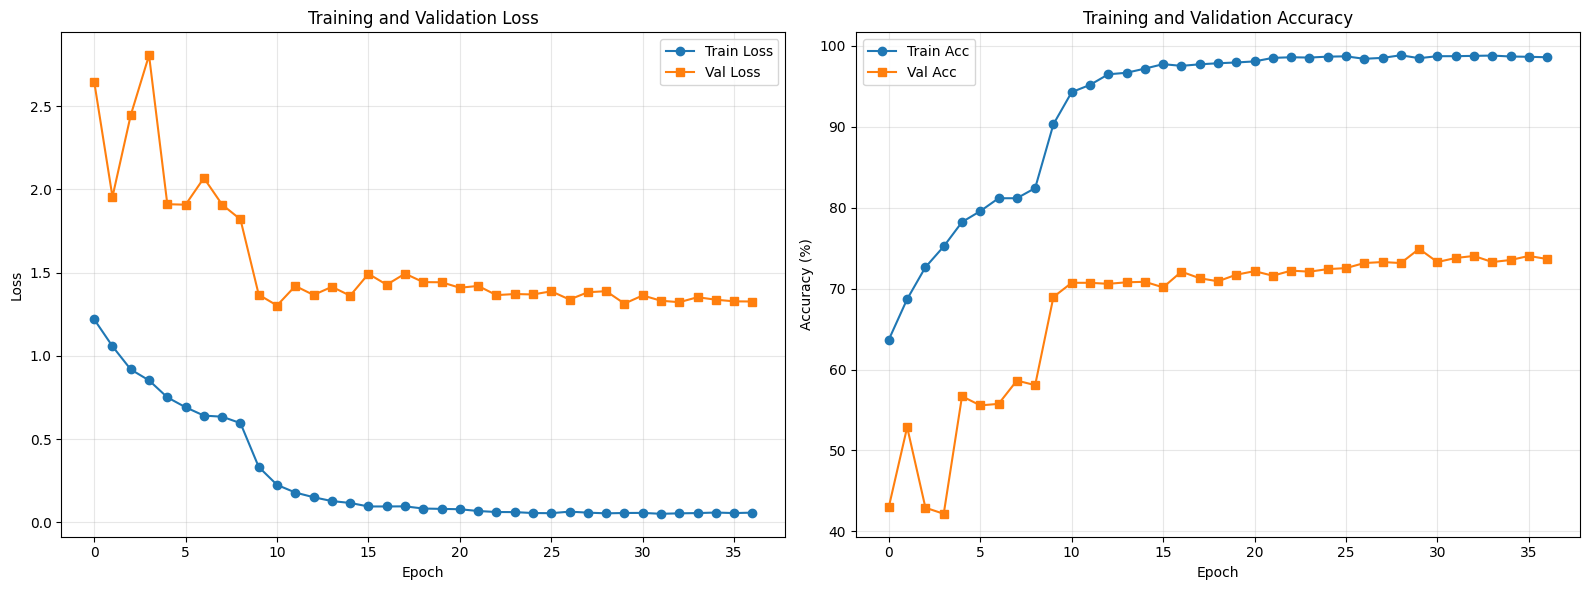


📊 Training Summary:
   Final Train Loss: 0.0581
   Final Train Acc: 98.58%
   Final Val Loss: 1.3263
   Final Val Acc: 73.65%
   Final Val F1: 0.7171


In [15]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy(%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n Training Summary:")
print(f" Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f" Final Train Acc: {history['train_acc'][-1]:.2f}%")
print(f" Final Val Loss: {history['val_loss'][-1]:.4f}")
print(f" Final Val Acc: {history['val_acc'][-1]:.2f}%")
print(f" Final Val F1: {history['val_f1'][-1]:.4f}")


## 🧪 Test Set Evaluation

Evaluate the trained model on the test set with detailed metrics.


In [22]:
# Load best model
model_save_path = CONFIG['MODEL_SAVE_DIR'] / f'best_model_{CONFIG["MODEL_NAME"]}.pth'
checkpoint = torch.load(model_save_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

print(f" Loaded best model from epoch {checkpoint['epoch']}")
print(f" Validation Accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate on test set
print("\n" +"=" * 80)
print("TEST SET EVALUATION")
print("=" * 80)

test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)

# Convert to numpy arrays
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)

# Calculate additional metrics
test_f1_weighted = f1_score(test_labels, test_preds, average='weighted')
test_f1_macro = f1_score(test_labels, test_preds, average='macro')
test_f1_per_class = f1_score(test_labels, test_preds, average=None)

print(f"\n Test Set Metrics:")
print(f" Loss: {test_loss:.4f}")
print(f" Accuracy: {test_acc:.2f}%")
print(f" Weighted F1-Score: {test_f1_weighted:.4f}")
print(f" Macro F1-Score: {test_f1_macro:.4f}")

# Per-class F1 scores
print(f"\n Per-Class F1-Scores:")
print(f"{'Class':<30s} {'F1-Score':<10s}")
print("-" * 40)
for i,(class_name, f1) in enumerate(zip(label_classes, test_f1_per_class)):
 print(f"{class_name:<30s} {f1:.4f}")


 Loaded best model from epoch 30
   Validation Accuracy: 74.91%

TEST SET EVALUATION
  Validation completed in 122.0s                              

📊 Test Set Metrics:
   Loss: 1.3254
   Accuracy: 75.85%
   Weighted F1-Score: 0.7387
   Macro F1-Score: 0.6956

📊 Per-Class F1-Scores:
Class                          F1-Score  
----------------------------------------
batteries                      0.6522
cans_all_type                  0.8606
ceramic_product                0.5660
coffee_tea_bags                0.7767
diapers                        0.7273
e-waste                        0.9077
egg_shells                     0.8276
food_scraps                    0.7534
glass_containers               0.7692
kitchen_waste                  0.1231
paints                         0.6333
paper_products                 0.7547
pesticides                     0.7234
plastic_bottles                0.7833
platics_bags_wrappers          0.5660
sanitary_napkin                0.5238
stroform_product         

## 📊 Classification Report and Confusion Matrix

Generate detailed classification report and confusion matrix.



CLASSIFICATION REPORT
                       precision    recall  f1-score   support

            batteries     1.0000    0.4839    0.6522        62
        cans_all_type     0.7802    0.9595    0.8606       148
      ceramic_product     1.0000    0.3947    0.5660        76
      coffee_tea_bags     0.6557    0.9524    0.7767        84
              diapers     0.5797    0.9756    0.7273        82
              e-waste     0.8356    0.9935    0.9077       307
           egg_shells     1.0000    0.7059    0.8276        68
          food_scraps     0.6131    0.9767    0.7534        86
     glass_containers     0.9615    0.6410    0.7692        78
        kitchen_waste     1.0000    0.0656    0.1231        61
               paints     0.4872    0.9048    0.6333        84
       paper_products     1.0000    0.6061    0.7547        66
           pesticides     0.5965    0.9189    0.7234        74
      plastic_bottles     0.8868    0.7015    0.7833        67
platics_bags_wrappers     1.000

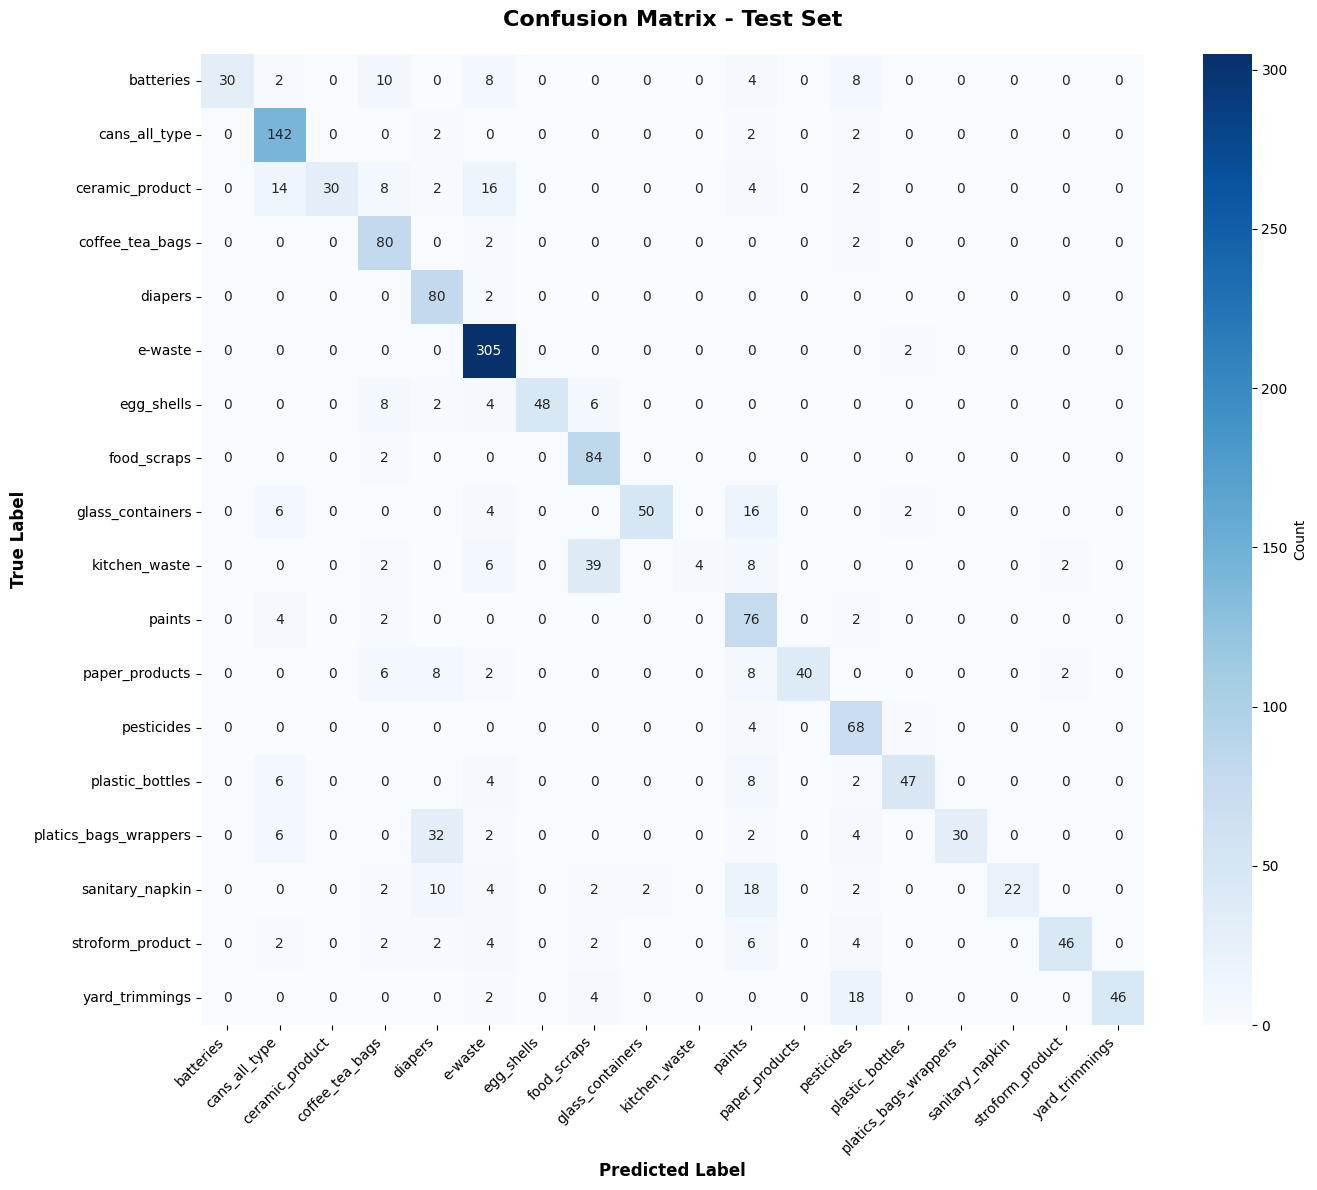


📊 Per-Class Accuracy:
Class                          Accuracy   Samples   
--------------------------------------------------
batteries                       48.39%       62
cans_all_type                   95.95%      148
ceramic_product                 39.47%       76
coffee_tea_bags                 95.24%       84
diapers                         97.56%       82
e-waste                         99.35%      307
egg_shells                      70.59%       68
food_scraps                     97.67%       86
glass_containers                64.10%       78
kitchen_waste                    6.56%       61
paints                          90.48%       84
paper_products                  60.61%       66
pesticides                      91.89%       74
plastic_bottles                 70.15%       67
platics_bags_wrappers           39.47%       76
sanitary_napkin                 35.48%       62
stroform_product                67.65%       68
yard_trimmings                  65.71%       70


In [23]:
# Classification report
print("\n" +"=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(
 test_labels, 
 test_preds, 
 target_names=label_classes,
 digits=4
))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
 cm, 
 annot=True, 
 fmt='d', 
 cmap='Blues',
 xticklabels=label_classes,
 yticklabels=label_classes,
 cbar_kws={'label':'Count'}
)
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\n Per-Class Accuracy:")
print(f"{'Class':<30s} {'Accuracy':<10s} {'Samples':<10s}")
print("-" * 50)
for i, class_name in enumerate(label_classes):
 class_mask =(test_labels == i)
 if class_mask.sum() > 0:
 class_acc =(test_preds[class_mask] == test_labels[class_mask]).mean() * 100
 class_count = class_mask.sum()
 print(f"{class_name:<30s} {class_acc:>6.2f}% {class_count:>6d}")
 else:
 print(f"{class_name:<30s} {'N/A':<10s} {'0':<10s}")


## 💾 Save Training Results

Save training history and evaluation results.


In [24]:
# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(CONFIG['MODEL_SAVE_DIR'] /'training_history.csv', index=False)

# Save evaluation results
eval_results = {
'test_loss': float(test_loss),
'test_accuracy': float(test_acc),
'test_f1_weighted': float(test_f1_weighted),
'test_f1_macro': float(test_f1_macro),
'per_class_f1': {label_classes[i]: float(f1) for i, f1 in enumerate(test_f1_per_class)},
'best_val_acc': float(best_val_acc),
'best_val_loss': float(best_val_loss),
'total_epochs': len(history['train_loss'])
}

with open(CONFIG['MODEL_SAVE_DIR'] /'evaluation_results.json','w') as f:
 json.dump(eval_results, f, indent=2)

print("=" * 80)
print("RESULTS SAVED")
print("=" * 80)
print(f" Training history: {CONFIG['MODEL_SAVE_DIR'] /'training_history.csv'}")
print(f" Evaluation results: {CONFIG['MODEL_SAVE_DIR'] /'evaluation_results.json'}")
print(f" Best model: {model_save_path}")
print(f"\n All results saved!")


RESULTS SAVED
   Training history: models\training_history.csv
   Evaluation results: models\evaluation_results.json
   Best model: models\best_model_resnet50.pth

✅ All results saved!


## 📋 Summary

### Training Results (Interpret from outputs above)
- **Best Validation Accuracy**: Check the training output above
- **Test Accuracy**: Check the test evaluation output above
- **Test Weighted F1-Score**: Review the test metrics output
- **Test Macro F1-Score**: Review the test metrics output

### Key Findings
- Review the confusion matrix to identify classes with high misclassification rates
- Check per-class F1-scores to identify weakest performing classes
- Compare test metrics with validation metrics to check for overfitting
- Analyze which classes are frequently confused with each other

### Next Steps
1. **Model Analysis**: Review confusion matrix for misclassification patterns
2. **Fine-tuning**: If needed, fine-tune hyperparameters or try different architectures
3. **Deployment**: Save model in deployment format (ONNX, TensorFlow Lite)
4. **Inference**: Create inference script for real-world predictions

---

## 🎯 Notes

### Model Performance Interpretation
- **Weighted F1-Score**: Accounts for class imbalance, good overall metric
- **Macro F1-Score**: Treats all classes equally, important for minority classes
- **Per-Class F1**: Identifies which classes need improvement
- **Confusion Matrix**: Shows which classes are confused with each other

### Training Insights
- Monitor the gap between train and validation accuracy (overfitting indicator)
- Check if validation loss stops improving (early stopping triggered)
- Review per-class performance, especially for safety-critical classes (batteries)
- Training history plots show model convergence and overfitting patterns

### Model Files Generated
- **Best model checkpoint**: Saved with all necessary information for inference
- **Training history**: CSV file with epoch-by-epoch metrics
- **Evaluation results**: JSON file with detailed test set metrics
